In [1]:
# Import necessary libraries and modules
import sys
sys.path.append("ACC_Project")

# Import custom classes from the llm_classes 
from llm_classes.textprocessing import TextProcessing
from llm_classes.block import Block
from llm_classes.config import Config
from llm_classes.dataprep import DataPrep, DataSet
from llm_classes.modeltrainer import ModelTrainer
from llm_classes.textprocessing import TextProcessing
from llm_classes.transformer import Transformer

# Import additional libraries for data handling and machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle
import torch as t
import pandas as pd
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Checking for GPU availability
device = "cuda" if t.cuda.is_available() else "cpu"

# Load the dataset and select relevant columns
df = pd.read_csv("processed_data.csv", low_memory=False)
df = df[["description", "label"]]

# Split the dataset into working and validation sets
df_wo_valid, df_valid = train_test_split(
    df, test_size=0.05, random_state=2, stratify=df.label
)


In [7]:
# Define a function to set up and train the llm
def setup_and_train_model(dataframe, extended_df, epochs):

    # Instantiate the Textprocessing class with the extended dataframe so vocab from validation set will be in tokenizer
    text_process = TextProcessing(df=extended_df, block_size=15)

    # Set up the configuration (model_paramaters)
    cfg = Config(
        epochs=epochs,
        batch_size=16,
        vocab_size=len(text_process.tokens),
        num_classes=len(text_process.labels),
    )

    # Encode the descriptions and labels
    dataprep = DataPrep(
        df=dataframe, test_size=0.2, textprocessing=text_process, cfg=cfg
    )

    # Create the model instance
    model = Transformer(cfg)

    # Split the data into training and testing sets
    train_data, test_data = dataprep.train_test(dataframe)

    # Define the loss function and optimizer for the model
    model_loss = nn.CrossEntropyLoss()
    model_optimizer = t.optim.RMSprop(model.parameters(), lr=4e-4)

    # Create the ModelTrainer instance and train the model
    trainer = ModelTrainer(
        model=model,
        train_data=train_data,
        test_data=test_data,
        optimizer=model_optimizer,
        loss_function=model_loss,
        device=device,
        cfg=cfg,
    )
    # Train the model
    trainer.train(epochs=epochs)

    return model, dataprep, text_process, dataprep, cfg

model, dataprep, textprocess, dataprep, cfg = setup_and_train_model(
    dataframe=df_wo_valid, extended_df=df, epochs=10
)


Epoch 0: Train Loss: 1.3689, Test Accuracy: 0.8923
Epoch 1: Train Loss: 1.1498, Test Accuracy: 0.8923
Epoch 2: Train Loss: 1.1482, Test Accuracy: 0.8923
Epoch 3: Train Loss: 1.1474, Test Accuracy: 0.8923
Epoch 4: Train Loss: 1.1462, Test Accuracy: 0.8923
Epoch 5: Train Loss: 1.1465, Test Accuracy: 0.8923
Epoch 6: Train Loss: 1.1461, Test Accuracy: 0.8923
Epoch 7: Train Loss: 1.1456, Test Accuracy: 0.8923
Epoch 8: Train Loss: 1.1185, Test Accuracy: 0.9785
Epoch 9: Train Loss: 1.0824, Test Accuracy: 0.9815


In [8]:
# Define a function to save objects
def save_file(item, name):
    pickle.dump(item, open("pickle_files/{}.pkl".format(name), "wb"))

# Save the trained model and data preparation objects
save_file(model, "llm_trained")
save_file(dataprep, "llm_data_prep")


In [9]:
# Load the trained model and data preparation objects 
model = pickle.load(open("pickle_files/llm_trained.pkl", "rb"))
val = pickle.load(open("pickle_files/llm_data_prep.pkl", "rb")).prep(
    df_valid, train=False
)


Category 'Income': Accuracy: 1.00
Category 'LSP Reimbursements Receivable': Accuracy: 1.00
Category 'Payroll': Accuracy: 1.00
Category 'Financing': Accuracy: 1.00
Category 'Bank Charges & Fees/Currency changes': Accuracy: 0.00
Category 'LSP cash payout': Accuracy: 1.00
Overall Accuracy: 0.99


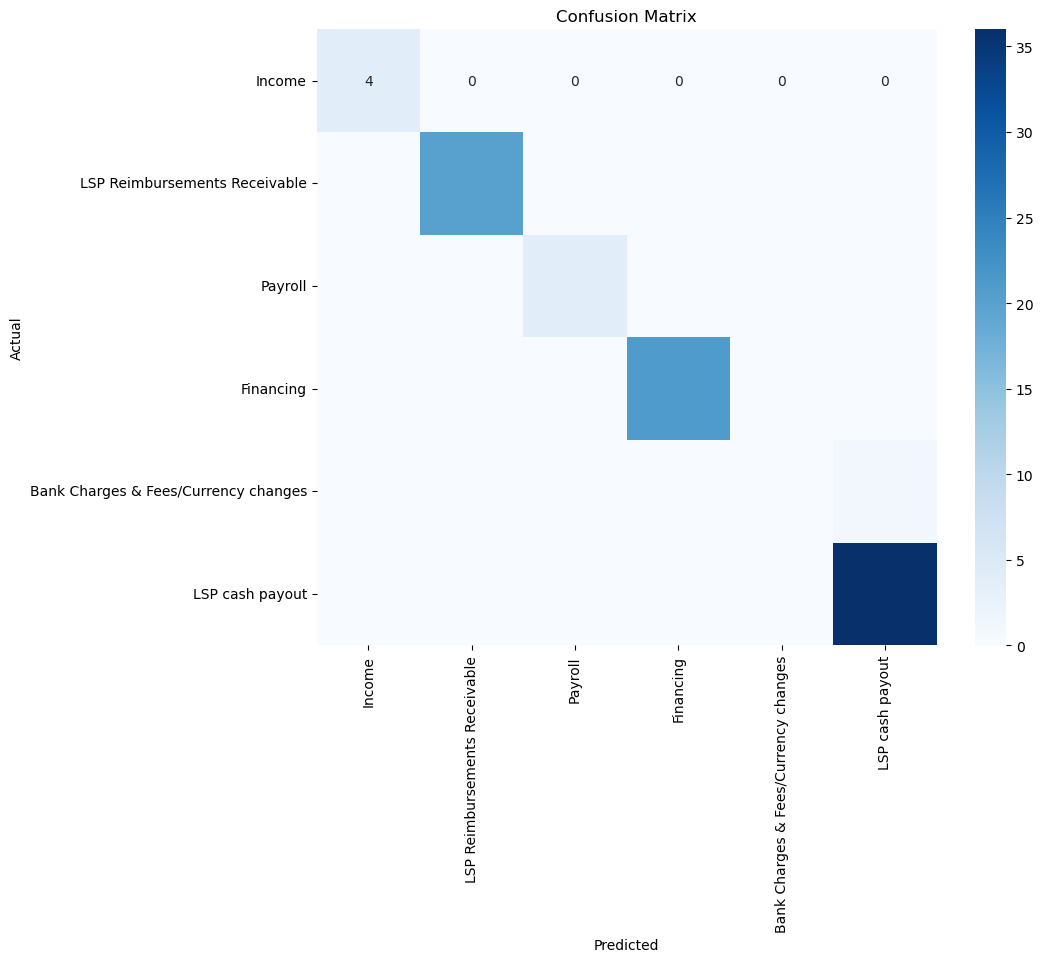

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def cat_accuracy(model, dl, idx_to_label):
    all_preds = []
    all_targets = []

    # Iterate over the validation dataset
    for inputs, targets in dl:
        inputs = inputs.to(device)  # Ensure the inputs are on the correct device
        with t.no_grad():  # No need to track gradients during validation
            outputs = model(inputs)
            _, predicted_classes = outputs.max(dim=1)
            all_preds.extend(predicted_classes.cpu().numpy())
            # Convert targets to class indices if they are one-hot encoded
            if targets.ndim > 1 and targets.size(1) > 1:
                targets = targets.argmax(dim=1)
            all_targets.extend(targets.cpu().numpy())

    # Calculate the confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    acc = accuracy_score(all_targets, all_preds)

    # Calculate per-class accuracy from the confusion matrix
    class_accuracy = cm.diagonal() / cm.sum(axis=1)

    # Print per-class accuracy with label names
    for i, accuracy in enumerate(class_accuracy):
        label_name = idx_to_label[i]
        print(f"Category '{label_name}': Accuracy: {accuracy:.2f}")

    print(f"Overall Accuracy: {acc:.2f}")

    # Plot confusion matrix with label names
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=idx_to_label.values(), yticklabels=idx_to_label.values())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    return cm, class_accuracy, acc

# Assuming you have a dictionary mapping indices to label names
labels = {
    label: number for number, label in enumerate(df.label.unique())
}  # Labels to numbers dictionary
reversed_labels = {v: k for k, v in labels.items()}
# Call the function with the validation dataloader and index-to-label mapping
cm, class_accuracy, overall_acc = cat_accuracy(model=model, dl=val, idx_to_label=reversed_labels)